In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = pd.read_csv("/content/drive/My Drive/NMT/Hindi_English_Corpus.csv")

In [5]:
data=data.drop('Unnamed: 0',axis=1)
data.head()

,english_sentence,hindi_sentence
0,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
1,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।
2,In this lies the circumstances of people befor...,इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।
3,Category: Religious Text,श्रेणी:धर्मग्रन्थ
4,This period summarily is pepped up with devotion.,यह काल समग्रतः भक्ति भावना से ओतप्रोत काल है।


In [6]:
data.shape

(45596, 2)

In [7]:
data = data.to_numpy()

In [8]:
english=data[:,0]
hindi=data[:,1]

In [9]:
english[:5]

array(['This percentage is even greater than the percentage in India.',
       '.The ending portion of these Vedas is called Upanishad.',
       'In this lies the circumstances of people before you.',
       'Category: Religious Text',
       'This period summarily is pepped up with devotion.'], dtype=object)

In [10]:
hindi[:5]

array(['यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।',
       'इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।',
       'इसमें तुमसे पूर्व गुज़रे हुए लोगों के हालात हैं।',
       'श्रेणी:धर्मग्रन्थ',
       'यह काल समग्रतः भक्ति भावना से ओतप्रोत काल है।'], dtype=object)

In [11]:
# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_english = -1
for doc in english:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_english < len(tokens)):
        maxlen_english = len(tokens)
print("The maximum number of words in any document = ", maxlen_english)

The maximum number of words in any document =  33


In [12]:
# Maximum length (number of words) per document. We will need it later for embeddings
maxlen_hindi = -1
for doc in hindi:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_hindi < len(tokens)):
        maxlen_hindi = len(tokens)
print("The maximum number of words in any document = ", maxlen_hindi)

The maximum number of words in any document =  24


In [13]:
def tokenize_and_pad(x, maxlen):
  #  a tokenier to tokenize the words and create sequences of tokenized words
  tokenizer = keras.preprocessing.text.Tokenizer(char_level = False)
  tokenizer.fit_on_texts(x)
  sequences = tokenizer.texts_to_sequences(x)
  padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = maxlen, padding = 'post')
  return tokenizer, sequences, padded

In [14]:
# tokenize and padding to the data 
x_tokenizer, x_sequences, x_padded = tokenize_and_pad(english, maxlen_english)
y_tokenizer, y_sequences, y_padded = tokenize_and_pad(hindi,  maxlen_hindi)

In [15]:
x_sequences[:5]

[[9, 1606, 7, 116, 1140, 117, 1, 1606, 5, 56],
 [1, 4841, 4132, 2, 37, 705, 7, 106, 7606],
 [5, 9, 2324, 1, 1893, 2, 41, 214, 10],
 [78, 342, 566],
 [9, 386, 10654, 7, 10655, 70, 21, 1392]]

In [16]:
np.array(x_sequences).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(45596,)

In [17]:
y_sequences[:5]

[[11, 294, 45, 4, 1714, 294, 7, 142, 13],
 [3339, 1502, 8, 1023, 185, 3340, 2160, 13],
 [180, 3866, 347, 9277, 111, 82, 2, 3867, 28],
 [34, 857],
 [11, 421, 7765, 1024, 604, 7, 7766, 421, 13]]

In [18]:
np.array(y_sequences).shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(45596,)

In [19]:
enc_vocab_size = len(x_tokenizer.index_word) + 1
dec_vocab_size = len(y_tokenizer.index_word) + 1
enc_vocab_size, dec_vocab_size

(21242, 22323)

*****************

In [20]:
# Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size = 0.1)

In [21]:
x_train.shape, y_train.shape

((41036, 33), (41036, 24))

In [22]:
x_test.shape, y_test.shape

((4560, 33), (4560, 24))

In [23]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('sparse_categorical_accuracy')>0.97):
      print("\nReached 97% accuracy so cancelling training!")
      self.model.stop_training = True


callbacks = myCallback()

In [24]:
def translator():
  model = keras.Sequential()

  model.add(keras.layers.Embedding(enc_vocab_size, 256, input_length = maxlen_english, mask_zero = True))

  model.add(keras.layers.LSTM(512, return_sequences=True))
  model.add(keras.layers.LSTM(512))
  

  model.add(keras.layers.RepeatVector(maxlen_hindi))

  model.add(keras.layers.LSTM(512, return_sequences= True ))
  model.add(keras.layers.LSTM(512, return_sequences= True ))
  
  model.add(keras.layers.Dense(dec_vocab_size, activation ='softmax'))

  return model



In [25]:
model = translator()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 256)           5437952   
_________________________________________________________________
lstm (LSTM)                  (None, 33, 512)           1574912   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 512)           2099200   
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 512)           2099200   
_________________________________________________________________
dense (Dense)                (None, 24, 22323)         1

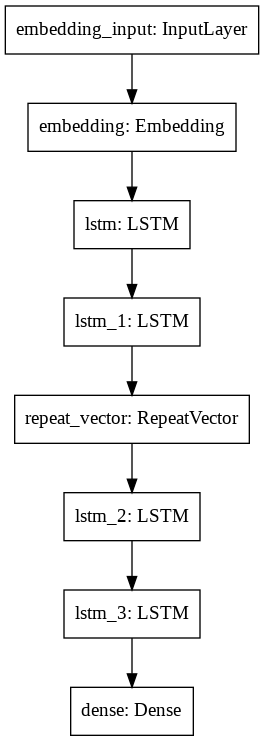

In [26]:
keras.utils.plot_model(model)

In [27]:
# change the shape of target from 2D to 3D
y_train = np.expand_dims(y_train, axis = 2)
y_train.shape

(41036, 24, 1)

In [35]:
# train the model
model.fit(x_train, y_train, epochs=400, batch_size=1024, validation_split= 0.1, callbacks=[callbacks], initial_epoch=200)

Epoch 201/400
37/37 [==============================] - 22s 592ms/step - loss: 0.5474 - sparse_categorical_accuracy: 0.8868 - val_loss: 2.2668 - val_sparse_categorical_accuracy: 0.7650
Epoch 202/400
37/37 [==============================] - 22s 590ms/step - loss: 0.5415 - sparse_categorical_accuracy: 0.8878 - val_loss: 2.2766 - val_sparse_categorical_accuracy: 0.7668
Epoch 203/400
37/37 [==============================] - 22s 591ms/step - loss: 0.5351 - sparse_categorical_accuracy: 0.8892 - val_loss: 2.2771 - val_sparse_categorical_accuracy: 0.7664
Epoch 204/400
37/37 [==============================] - 22s 591ms/step - loss: 0.5329 - sparse_categorical_accuracy: 0.8895 - val_loss: 2.2847 - val_sparse_categorical_accuracy: 0.7663
Epoch 205/400
37/37 [==============================] - 22s 592ms/step - loss: 0.5297 - sparse_categorical_accuracy: 0.8901 - val_loss: 2.2825 - val_sparse_categorical_accuracy: 0.7651
Epoch 206/400
37/37 [==============================] - 22s 591ms/step - loss: 0.

In [36]:
# save the model

model.save("/content/drive/My Drive/NMT/weights(8).h5")

*******

In [37]:
# function to make prediction
def prediction(x, x_tokenizer = x_tokenizer, y_tokenizer = y_tokenizer):
    predictions = model.predict(x)[0]
    id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
    id_to_word[0] = ''
    return ' '.join([id_to_word[j] for j in np.argmax(predictions,1)])

In [54]:
# function to obtain the text from padded variables
def pad_to_text(padded, tokenizer):

    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = ''
    padded = padded.flatten()
    return ' '.join([id_to_word[j] for j in  [i for i in padded]])

In [57]:
from nltk.translate.bleu_score import sentence_bleu

In [60]:
for i in range(1, 10):
  y = pad_to_text(y_train[i], y_tokenizer)
  y_pred = prediction(x_train[i:i+1])
  print('Original English word - {}\n'.format(pad_to_text(x_train[i], x_tokenizer)))
  print('Original Hindi word - {}\n'.format(y))
  print('Predicted Hindi word - {}\n'.format(y_pred))
  score = sentence_bleu(y, y_pred)
  print('Bleu Score:  ', score, '\n\n\n')

Original English word - it is the shop 's responsibility to collect them                        

Original Hindi word - उन्हें ले जाने की ज़िम्मेदारी दुकानदार की है                

Predicted Hindi word - उन्हें ले से की ज़िम्मेदारी दुकानदार की है                

Bleu Score:   0.7565391407404769 



Original English word - and one bowl of delicious goldfish crackers                          

Original Hindi word - और एक में स्वादिष्ट गोल्डफ़िश जैसे बिस्कुट।                 

Predicted Hindi word - और एक में स्वादिष्ट गोल्डफ़िश जैसे बिस्कुट।                 

Bleu Score:   0.8265168183793802 



Original English word - they kind of chose suspicion                            

Original Hindi word - उन्होंने एक प्रकार से संदेह चुना                  

Predicted Hindi word - उन्होंने एक प्रकार से संदेह चुना                  

Bleu Score:   0.7636066981663598 



Original English word - so think of it as a monitor for the blind                       

Original Hindi word - इसे नेत्रहीन के ल

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Original English word - headquarter of youtube is in san bruno                          

Original Hindi word - यूट्यूब का मुख्यालय सैन ब्रुनॊ में है                 

Predicted Hindi word - यूट्यूब का मुख्यालय सैन ब्रुनॊ में है                 

Bleu Score:   0.7801157731069053 



Original English word - this is 40 metre height                            

Original Hindi word - यह प्रत्येक 40 मीटर ऊँची है।                  

Predicted Hindi word - यह प्रत्येक 40 मीटर ऊँची है।                  

Bleu Score:   0.8016761109807073 



Original English word - my favorite is sophocles' “oedipus the king ”                         

Original Hindi word - मेरा पसंदीदा है “sophocles ईडिपस राजा”                  

Predicted Hindi word - मेरा पसंदीदा है “sophocles ईडिपस राजा”                  

Bleu Score:   0.8174063278327743 



Original English word - so flying versus driving                             

Original Hindi word - जैसे हवाई जहाज की अपेक्षा कार का सफ़र                

Predicted H

In [61]:
for i in range(1, 10):
  y = pad_to_text(y_test[i], y_tokenizer)
  y_pred = prediction(x_test[i:i+1])
  print('Original English word - {}\n'.format(pad_to_text(x_test[i], x_tokenizer)))
  print('Original Hindi word - {}\n'.format(y))
  print('Predicted Hindi word - {}\n'.format(y_pred))
  score = sentence_bleu(y, y_pred)
  print('Bleu Score:  ', score, '\n\n\n')

Original English word - many millions of pilgrims come each year mandiroanmen                         

Original Hindi word - कई मन्दिरों में हर साल लाखों तीर्थयात्री आते हैं।               

Predicted Hindi word - इन कई कई के में एक फैसले मर किया है।              

Bleu Score:   0.7521206186172787 



Original English word - hockey is the national sport                            

Original Hindi word - हॉकी राष्ट्रीय खेल है ।                   

Predicted Hindi word - झुला में पूर्ण गुब्बारा है                   

Bleu Score:   0.6493358309501979 



Original English word - but that's only half the story                           

Original Hindi word - मगर ये सिर्फ़ आधी ही कहानी है।                 

Predicted Hindi word - पर ये ये ये ये दूसरी कहानी है                

Bleu Score:   0.7031452428005499 



Original English word - thank you sk thank you                            

Original Hindi word - धन्यवाद। सलमान ख़ान धन्यवाद।                    

Predicted Hindi word - आप आज आपक

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Original English word - chinese students coming elsewhere and going to school                         

Original Hindi word - चीनी छात्र दूसरी जगह आ कर स्कूल जा रहे थे              

Predicted Hindi word - और चुपचाप दोस्त और और और मौका चाहता था               

Bleu Score:   0.674961814926904 



Original English word - kepler won't find a planet                            

Original Hindi word - केपलर हर उस तारे के आसपास ग्रह नहीं                

Predicted Hindi word - इन सभी द्वारा पर पर तकनीक हैं                 

Bleu Score:   0.7146704964214272 



Original English word - kokani goanese from kokan or goa region                          

Original Hindi word - कोंकणी गोआनी                      

Predicted Hindi word - एम एम से पीछे भी भी वेतन हैं                

Bleu Score:   0.5491004867761125 



Original English word - and they will double their energy use                          

Original Hindi word - और ऊर्जा का उपयोग दुगुना कर देंगे                 

Predicted Hindi word -

***************

## Ignore


In [33]:
#model = keras.models.load_model("/content/drive/My Drive/NMT/weights(5).h5")

In [34]:
'''test_eng[:5]'''

NameError: ignored

In [ ]:
'''test_hindi[:5]'''

In [ ]:
'''for i in test_eng[0]:
  if i not in  [0, 1, 2]:
    print(eng_tokenizer.index_word[i], end=' ')
'''

In [ ]:
'''for i in test_hindi[0]:
  if i not in  [0, 1, 2]:
    print(hindi_tokenizer.index_word[i], end=' ')
'''

In [ ]:
'''hindi_pred = model.predict(eng_tokenized_test[0])

output_id=tf.math.argmax(hindi_pred[0], 1)
print(output_id)
for i in output_id:
  if i not in  [0, 1, 2]:
    print(hindi_tokenizer.index_word[i.numpy], end=' ')'''

In [ ]:
#eng_tokenized_test[0]

In [ ]:
#hindi_pred = model.predict(eng_tokenized_test[0])
#hindi_pred

In [ ]:
#output_id = tf.math.argmax(hindi_pred,-1)
#output_id

In [ ]:
#output_id = output_id[4][1].numpy()
#output_id

In [ ]:
#hindi_tokenizer_test.index_word[output_id]

In [ ]:
#english_test[0]

In [ ]:
#hindi_test[0]